<h1>Using LightGBM classifier on credit card default data to predict default rate. </h1>

This notebook explores an application of the LightGBM package by Microsoft with a clean dataset on credit card defaults. Since we are trying to predict if a person is defaulting or not, we will want to use binary classification. This notebook also explores early stopping, is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. 


Dataset source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. 

In [161]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import auc, accuracy_score, roc_auc_score

In [162]:
data = pd.read_excel('ccdata.xls', header = 1)

In [126]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


In [128]:
data.drop('ID', axis = 1, inplace = True)

In [129]:
# Check for null values.
data.isnull().sum().sort_values(ascending=False)

default payment next month    0
PAY_AMT6                      0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
LIMIT_BAL                     0
dtype: int64

In [130]:
X = data.drop(['default payment next month'], axis=1)
y = data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

<h2>LightGBM classifier hyperparameter optimization via scikit-learn's GridSearchCV</h2>

In [178]:
estimator = lgb.LGBMClassifier(objective='binary', class_weight = 'is_unbalance' )
param_grid = {
    'n_estimators' : [x for x in range(10, 30)],
    'learning_rate' : [0.15, 0.2, 0.25],
    'num_leaves': [30],
    'metric': ['l1', 'l2']
}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)



[1]	valid_0's binary_logloss: 0.629798	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583147	valid_0's auc: 0.777521
[3]	valid_0's binary_logloss: 0.548263	valid_0's auc: 0.779072
[4]	valid_0's binary_logloss: 0.521659	valid_0's auc: 0.779134
[5]	valid_0's binary_logloss: 0.501249	valid_0's auc: 0.779596
[6]	valid_0's binary_logloss: 0.485267	valid_0's auc: 0.779882
[7]	valid_0's binary_logloss: 0.472825	valid_0's auc: 0.780576
[8]	valid_0's binary_logloss: 0.463177	valid_0's auc: 0.780501
[9]	valid_0's binary_logloss: 0.455419	valid_0's auc: 0.781428
[10]	valid_0's binary_logloss: 0.449803	valid_0's auc: 0.780891
[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.77

[3]	valid_0's binary_logloss: 0.548263	valid_0's auc: 0.779072
[4]	valid_0's binary_logloss: 0.521659	valid_0's auc: 0.779134
[5]	valid_0's binary_logloss: 0.501249	valid_0's auc: 0.779596
[6]	valid_0's binary_logloss: 0.485267	valid_0's auc: 0.779882
[7]	valid_0's binary_logloss: 0.472825	valid_0's auc: 0.780576
[8]	valid_0's binary_logloss: 0.463177	valid_0's auc: 0.780501
[9]	valid_0's binary_logloss: 0.455419	valid_0's auc: 0.781428
[10]	valid_0's binary_logloss: 0.449803	valid_0's auc: 0.780891
[11]	valid_0's binary_logloss: 0.445455	valid_0's auc: 0.780333
[12]	valid_0's binary_logloss: 0.441859	valid_0's auc: 0.780373
[13]	valid_0's binary_logloss: 0.439073	valid_0's auc: 0.780393
[14]	valid_0's binary_logloss: 0.436941	valid_0's auc: 0.780343
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.455419	valid_0's auc: 0.781428
[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's bin

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.

[11]	valid_0's binary_logloss: 0.445088	valid_0's auc: 0.780521
[12]	valid_0's binary_logloss: 0.441275	valid_0's auc: 0.781468
[13]	valid_0's binary_logloss: 0.438532	valid_0's auc: 0.781618
[14]	valid_0's binary_logloss: 0.436034	valid_0's auc: 0.782839
[15]	valid_0's binary_logloss: 0.434449	valid_0's auc: 0.782665
[16]	valid_0's binary_logloss: 0.433002	valid_0's auc: 0.783033
[17]	valid_0's binary_logloss: 0.431537	valid_0's auc: 0.784143
[18]	valid_0's binary_logloss: 0.430627	valid_0's auc: 0.784615
[19]	valid_0's binary_logloss: 0.430048	valid_0's auc: 0.784131
[1]	valid_0's binary_logloss: 0.629798	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583147	valid_0's auc: 0.777521
[3]	valid_0's binary_logloss: 0.548263	valid_0's auc: 0.779072
[4]	valid_0's binary_logloss: 0.521659	valid_0's auc: 0.779134
[5]	valid_0's binary_logloss: 0.501249	valid_0's auc: 0.779596
[6]	valid_0's binary_logloss: 0.485267	valid_0's

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.

[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.784385
[16]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.784972
[17]	valid_0's binary_logloss: 0.430694	valid_0's auc: 0.784872
[18]	valid_0's binary_logloss: 0.430282	valid_0's auc: 0.784011
[19]	valid_0's binary_logloss: 0.429472	valid_0's auc: 0.784971
[20]	valid_0's binary_logloss: 0.429264	valid_0's auc: 0.784028
[21]	valid_0's binary_logloss: 0.429028	valid_0's auc: 0.784337
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.431576	valid_0's auc: 0.784972
[1]	valid_0

[1]	valid_0's binary_logloss: 0.629911	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583605	valid_0's auc: 0.769771
[3]	valid_0's binary_logloss: 0.548186	valid_0's auc: 0.777321
[4]	valid_0's binary_logloss: 0.521575	valid_0's auc: 0.776883
[5]	valid_0's binary_logloss: 0.500959	valid_0's auc: 0.779713
[6]	valid_0's binary_logloss: 0.485185	valid_0's auc: 0.779289
[7]	valid_0's binary_logloss: 0.472859	valid_0's auc: 0.778946
[8]	valid_0's binary_logloss: 0.46331	valid_0's auc: 0.779194
[9]	valid_0's binary_logloss: 0.456074	valid_0's auc: 0.778809
[10]	valid_0's binary_logloss: 0.449967	valid_0's auc: 0.780138
[11]	valid_0's binary_logloss: 0.445088	valid_0's auc: 0.780521
[12]	valid_0's binary_logloss: 0.441275	valid_0's auc: 0.781468
[13]	valid_0's binary_logloss: 0.438532	valid_0's auc: 0.781618
[14]	valid_0's binary_logloss: 0.436034	valid_0's auc: 0.782839
[15]	valid_0's binary_logloss: 0.434449	valid_0's auc

[1]	valid_0's binary_logloss: 0.629798	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583147	valid_0's auc: 0.777521
[3]	valid_0's binary_logloss: 0.548263	valid_0's auc: 0.779072
[4]	valid_0's binary_logloss: 0.521659	valid_0's auc: 0.779134
[5]	valid_0's binary_logloss: 0.501249	valid_0's auc: 0.779596
[6]	valid_0's binary_logloss: 0.485267	valid_0's auc: 0.779882
[7]	valid_0's binary_logloss: 0.472825	valid_0's auc: 0.780576
[8]	valid_0's binary_logloss: 0.463177	valid_0's auc: 0.780501
[9]	valid_0's binary_logloss: 0.455419	valid_0's auc: 0.781428
[10]	valid_0's binary_logloss: 0.449803	valid_0's auc: 0.780891
[11]	valid_0's binary_logloss: 0.445455	valid_0's auc: 0.780333
[12]	valid_0's binary_logloss: 0.441859	valid_0's auc: 0.780373
[13]	valid_0's binary_logloss: 0.439073	valid_0's auc: 0.780393
[14]	valid_0's binary_logloss: 0.436941	valid_0's auc: 0.780343
Early stopping, best iteration is:
[9]	valid_0's bin

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.629911	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583605	valid_0's auc: 0.76977

[1]	valid_0's binary_logloss: 0.629911	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583605	valid_0's auc: 0.769771
[3]	valid_0's binary_logloss: 0.548186	valid_0's auc: 0.777321
[4]	valid_0's binary_logloss: 0.521575	valid_0's auc: 0.776883
[5]	valid_0's binary_logloss: 0.500959	valid_0's auc: 0.779713
[6]	valid_0's binary_logloss: 0.485185	valid_0's auc: 0.779289
[7]	valid_0's binary_logloss: 0.472859	valid_0's auc: 0.778946
[8]	valid_0's binary_logloss: 0.46331	valid_0's auc: 0.779194
[9]	valid_0's binary_logloss: 0.456074	valid_0's auc: 0.778809
[10]	valid_0's binary_logloss: 0.449967	valid_0's auc: 0.780138
[11]	valid_0's binary_logloss: 0.445088	valid_0's auc: 0.780521
[12]	valid_0's binary_logloss: 0.441275	valid_0's auc: 0.781468
[13]	valid_0's binary_logloss: 0.438532	valid_0's auc: 0.781618
[14]	valid_0's binary_logloss: 0.436034	valid_0's auc: 0.782839
[15]	valid_0's binary_logloss: 0.434449	valid_0's auc

[1]	valid_0's binary_logloss: 0.629911	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583605	valid_0's auc: 0.769771
[3]	valid_0's binary_logloss: 0.548186	valid_0's auc: 0.777321
[4]	valid_0's binary_logloss: 0.521575	valid_0's auc: 0.776883
[5]	valid_0's binary_logloss: 0.500959	valid_0's auc: 0.779713
[6]	valid_0's binary_logloss: 0.485185	valid_0's auc: 0.779289
[7]	valid_0's binary_logloss: 0.472859	valid_0's auc: 0.778946
[8]	valid_0's binary_logloss: 0.46331	valid_0's auc: 0.779194
[9]	valid_0's binary_logloss: 0.456074	valid_0's auc: 0.778809
[10]	valid_0's binary_logloss: 0.449967	valid_0's auc: 0.780138
[11]	valid_0's binary_logloss: 0.445088	valid_0's auc: 0.780521
[12]	valid_0's binary_logloss: 0.441275	valid_0's auc: 0.781468
[13]	valid_0's binary_logloss: 0.438532	valid_0's auc: 0.781618
[14]	valid_0's binary_logloss: 0.436034	valid_0's auc: 0.782839
[15]	valid_0's binary_logloss: 0.434449	valid_0's auc

[1]	valid_0's binary_logloss: 0.629798	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583147	valid_0's auc: 0.777521
[3]	valid_0's binary_logloss: 0.548263	valid_0's auc: 0.779072
[4]	valid_0's binary_logloss: 0.521659	valid_0's auc: 0.779134
[5]	valid_0's binary_logloss: 0.501249	valid_0's auc: 0.779596
[6]	valid_0's binary_logloss: 0.485267	valid_0's auc: 0.779882
[7]	valid_0's binary_logloss: 0.472825	valid_0's auc: 0.780576
[8]	valid_0's binary_logloss: 0.463177	valid_0's auc: 0.780501
[9]	valid_0's binary_logloss: 0.455419	valid_0's auc: 0.781428
[10]	valid_0's binary_logloss: 0.449803	valid_0's auc: 0.780891
[11]	valid_0's binary_logloss: 0.445455	valid_0's auc: 0.780333
[12]	valid_0's binary_logloss: 0.441859	valid_0's auc: 0.780373
[13]	valid_0's binary_logloss: 0.439073	valid_0's auc: 0.780393
[14]	valid_0's binary_logloss: 0.436941	valid_0's auc: 0.780343
Early stopping, best iteration is:
[9]	valid_0's bin

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.

[1]	valid_0's binary_logloss: 0.629241	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.582485	valid_0's auc: 0.776705
[3]	valid_0's binary_logloss: 0.547288	valid_0's auc: 0.777114
[4]	valid_0's binary_logloss: 0.520432	valid_0's auc: 0.778967
[5]	valid_0's binary_logloss: 0.499855	valid_0's auc: 0.779302
[6]	valid_0's binary_logloss: 0.484148	valid_0's auc: 0.780204
[7]	valid_0's binary_logloss: 0.471668	valid_0's auc: 0.78182
[8]	valid_0's binary_logloss: 0.462018	valid_0's auc: 0.782493
[9]	valid_0's binary_logloss: 0.454337	valid_0's auc: 0.78264
[10]	valid_0's binary_logloss: 0.44845	valid_0's auc: 0.782369
[11]	valid_0's binary_logloss: 0.44405	valid_0's auc: 0.781952
[12]	valid_0's binary_logloss: 0.44074	valid_0's auc: 0.782379
[13]	valid_0's binary_logloss: 0.437598	valid_0's auc: 0.783089
[14]	valid_0's binary_logloss: 0.435225	valid_0's auc: 0.783486
[15]	valid_0's binary_logloss: 0.433182	valid_0's auc: 0.

[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55572	valid_0's auc: 0.776393
[3]	valid_0's binary_logloss: 0.518342	valid_0's auc: 0.779899
[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_logloss: 0.519249	valid_0's auc: 0.779053
[4]	valid_0's binary_logloss: 0.492864	valid_0's auc: 0.779352
[5]	valid_0's binary_logloss: 0.474366	valid_0's auc: 0.779418
[6]	valid_0's binary_logloss: 0.461338	valid_0's auc: 0.780117
[7]	valid_0's binary_logloss: 0.451942	valid_0's auc: 0.780882
[8]	valid_0's binary_logloss: 0.445453	valid_0's auc: 0.780156
[9]	valid_0's binary_logloss: 0.440416	valid_0's auc: 0.780781
[10]	valid_0's binary_logloss: 0.436393	valid_0's auc: 0.782675
[11]	valid_0's binary_logloss: 0.433967	valid_0's auc: 0.78254
[12]	valid_0's binary_logloss: 0.432556	valid_0's auc: 0.782213
[13]	valid_0's binary_logloss: 0.431327	valid_0's auc: 0.782193
[14]	valid_0's binary_logloss: 0.430367	valid_0's auc: 0.7824
[15]	valid_0's binary_logloss: 0.429826	valid_0's auc: 

[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55572	valid_0's auc: 0.776393
[3]	valid_0's binary_logloss: 0.518342	valid_0's auc: 0.779899
[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55572	valid_0's auc: 0.776393
[3]	valid_0's binary_logloss: 0.518342	valid_0's auc: 0.779899
[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55572	valid_0's auc: 0.776393
[3]	valid_0's binary_logloss: 0.518342	valid_0's auc: 0.779899
[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.610964	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556538	valid_0's auc: 0.776053
[3]	valid_0's binary_logloss: 0.51964	valid_0's auc: 0.779311
[4]	valid_0's binary_logloss: 0.493734	valid_0's auc: 0.778904
[5]	valid_0's binary_logloss: 0.475067	valid_0's auc: 0.778925
[6]	valid_0's binary_logloss: 0.462292	valid_0's auc: 0.779197
[7]	valid_0's binary_logloss: 0.452998	valid_0's auc: 0.779176
[8]	valid_0's binary_logloss: 0.446534	valid_0's auc: 0.780202
[9]	valid_0's binary_logloss: 0.441663	valid_0's auc: 0.780888
[10]	valid_0's binary_logloss: 0.438508	valid_0's auc: 0.780221
[11]	valid_0's binary_logloss: 0.43609	valid_0's auc: 0.780138
[12]	valid_0's binary_logloss: 0.434106	valid_0's auc: 0.780889
[13]	valid_0's binary_logloss: 0.432126	valid_0's auc: 0.783443
[14]	valid_0's binary_logloss: 0.431075	valid_0's auc: 0.783816
[15]	valid_0's binary_logloss: 0.430876	valid_0's auc:

[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_logloss: 0.519249	valid_0's auc: 0.779053
[4]	valid_0's binary_logloss: 0.492864	valid_0's auc: 0.779352
[5]	valid_0's binary_logloss: 0.474366	valid_0's auc: 0.779418
[6]	valid_0's binary_logloss: 0.461338	valid_0's auc: 0.780117
[7]	valid_0's binary_logloss: 0.451942	valid_0's auc: 0.780882
[8]	valid_0's binary_logloss: 0.445453	valid_0's auc: 0.780156
[9]	valid_0's binary_logloss: 0.440416	valid_0's auc: 0.780781
[10]	valid_0's binary_logloss: 0.436393	valid_0's auc: 0.782675
[11]	valid_0's binary_logloss: 0.433967	valid_0's auc: 0.78254
[12]	valid_0's binary_logloss: 0.432556	valid_0's auc: 0.782213
[13]	valid_0's binary_logloss: 0.431327	valid_0's auc: 0.782193
[14]	valid_0's binary_logloss: 0.430367	valid_0's auc: 0.7824
[15]	valid_0's binary_logloss: 0.429826	valid_0's auc: 

[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_logloss: 0.519249	valid_0's auc: 0.779053
[4]	valid_0's binary_logloss: 0.492864	valid_0's auc: 0.779352
[5]	valid_0's binary_logloss: 0.474366	valid_0's auc: 0.779418
[6]	valid_0's binary_logloss: 0.461338	valid_0's auc: 0.780117
[7]	valid_0's binary_

[4]	valid_0's binary_logloss: 0.493734	valid_0's auc: 0.778904
[5]	valid_0's binary_logloss: 0.475067	valid_0's auc: 0.778925
[6]	valid_0's binary_logloss: 0.462292	valid_0's auc: 0.779197
[7]	valid_0's binary_logloss: 0.452998	valid_0's auc: 0.779176
[8]	valid_0's binary_logloss: 0.446534	valid_0's auc: 0.780202
[9]	valid_0's binary_logloss: 0.441663	valid_0's auc: 0.780888
[10]	valid_0's binary_logloss: 0.438508	valid_0's auc: 0.780221
[11]	valid_0's binary_logloss: 0.43609	valid_0's auc: 0.780138
[12]	valid_0's binary_logloss: 0.434106	valid_0's auc: 0.780889
[13]	valid_0's binary_logloss: 0.432126	valid_0's auc: 0.783443
[14]	valid_0's binary_logloss: 0.431075	valid_0's auc: 0.783816
[15]	valid_0's binary_logloss: 0.430876	valid_0's auc: 0.783282
[16]	valid_0's binary_logloss: 0.430382	valid_0's auc: 0.783604
[17]	valid_0's binary_logloss: 0.430402	valid_0's auc: 0.782538
[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve f

[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55572	valid_0's auc: 0.776393
[3]	valid_0's binary_logloss: 0.518342	valid_0's auc: 0.779899
[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.610253	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.55572	valid_0's auc: 0.776393
[3]	valid_0's binary_logloss: 0.518342	valid_0's auc: 0.779899
[4]	valid_0's binary_logloss: 0.492386	valid_0's auc: 0.779419
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[6]	valid_0's binary_logloss: 0.461228	valid_0's auc: 0.780343
[7]	valid_0's binary_logloss: 0.452007	valid_0's auc: 0.779919
[8]	valid_0's binary_logloss: 0.445476	valid_0's auc: 0.780188
[9]	valid_0's binary_logloss: 0.440777	valid_0's auc: 0.780542
[10]	valid_0's binary_logloss: 0.437241	valid_0's auc: 0.780758
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.473661	valid_0's auc: 0.782379
[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.610964	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556538	valid_0's auc: 0.776053
[3]	valid_0's binary_logloss: 0.51964	valid_0's auc: 0.779311
[4]	valid_0's binary_logloss: 0.493734	valid_0's auc: 0.778904
[5]	valid_0's binary_logloss: 0.475067	valid_0's auc: 0.778925
[6]	valid_0's binary_logloss: 0.462292	valid_0's auc: 0.779197
[7]	valid_0's binary_logloss: 0.452998	valid_0's auc: 0.779176
[8]	valid_0's binary_logloss: 0.446534	valid_0's auc: 0.780202
[9]	valid_0's binary_logloss: 0.441663	valid_0's auc: 0.780888
[10]	valid_0's binary_logloss: 0.438508	valid_0's auc: 0.780221
[11]	valid_0's binary_logloss: 0.43609	valid_0's auc: 0.780138
[12]	valid_0's binary_logloss: 0.434106	valid_0's auc: 0.780889
[13]	valid_0's binary_logloss: 0.432126	valid_0's auc: 0.783443
[14]	valid_0's binary_logloss: 0.431075	valid_0's auc: 0.783816
[15]	valid_0's binary_logloss: 0.430876	valid_0's auc:

[1]	valid_0's binary_logloss: 0.611125	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556657	valid_0's auc: 0.774815
[3]	valid_0's binary_logloss: 0.519249	valid_0's auc: 0.779053
[4]	valid_0's binary_logloss: 0.492864	valid_0's auc: 0.779352
[5]	valid_0's binary_logloss: 0.474366	valid_0's auc: 0.779418
[6]	valid_0's binary_logloss: 0.461338	valid_0's auc: 0.780117
[7]	valid_0's binary_logloss: 0.451942	valid_0's auc: 0.780882
[8]	valid_0's binary_logloss: 0.445453	valid_0's auc: 0.780156
[9]	valid_0's binary_logloss: 0.440416	valid_0's auc: 0.780781
[10]	valid_0's binary_logloss: 0.436393	valid_0's auc: 0.782675
[11]	valid_0's binary_logloss: 0.433967	valid_0's auc: 0.78254
[12]	valid_0's binary_logloss: 0.432556	valid_0's auc: 0.782213
[13]	valid_0's binary_logloss: 0.431327	valid_0's auc: 0.782193
[14]	valid_0's binary_logloss: 0.430367	valid_0's auc: 0.7824
[15]	valid_0's binary_logloss: 0.429826	valid_0's auc: 

[9]	valid_0's binary_logloss: 0.434726	valid_0's auc: 0.780001
[10]	valid_0's binary_logloss: 0.433126	valid_0's auc: 0.780206
[11]	valid_0's binary_logloss: 0.431813	valid_0's auc: 0.780965
[12]	valid_0's binary_logloss: 0.430426	valid_0's auc: 0.78175
[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.593255	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533938	valid_0's auc: 0.77571
[3]	valid_0's binary_logloss: 0.497463	valid_0's auc: 0.776953
[4]	valid_0's binary_logloss: 0.473611	valid_0's auc: 0.777331
[5]	valid_0's binary_logloss: 0.458136	valid_0's auc: 0.778402
[6]	valid_0's binary_logloss: 0.448276	valid_0's auc: 0.779264
[7]	valid_0's binary_logloss: 0.441668	valid_0's auc: 0.780647
[8]	valid_0's binary_logloss: 0.437144	valid_0's auc: 0.781164
[9]	valid_0's binary_logloss: 0.434726	valid_0's auc: 0.780001
[10]	valid_0's binary_logloss: 0.433126	valid_0's auc: 0.780206
[11]	valid_0's binary_logloss: 0.431813	valid_0's auc: 0.780965
[12]	valid_0's binary_logloss: 0.430426	valid_0's auc: 0.78175
[13]	valid_0's binary_logloss: 0.429609	valid_0's auc: 0.782416
[14]	valid_0's binary_logloss: 0.429506	valid_0's auc: 0.78208
[15]	valid_0's binary_logloss: 0.429558	valid_0's auc: 

[1]	valid_0's binary_logloss: 0.593255	valid_0's auc: 0.768968
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533938	valid_0's auc: 0.77571
[3]	valid_0's binary_logloss: 0.497463	valid_0's auc: 0.776953
[4]	valid_0's binary_logloss: 0.473611	valid_0's auc: 0.777331
[5]	valid_0's binary_logloss: 0.458136	valid_0's auc: 0.778402
[6]	valid_0's binary_logloss: 0.448276	valid_0's auc: 0.779264
[7]	valid_0's binary_logloss: 0.441668	valid_0's auc: 0.780647
[8]	valid_0's binary_logloss: 0.437144	valid_0's auc: 0.781164
[9]	valid_0's binary_logloss: 0.434726	valid_0's auc: 0.780001
[10]	valid_0's binary_logloss: 0.433126	valid_0's auc: 0.780206
[11]	valid_0's binary_logloss: 0.431813	valid_0's auc: 0.780965
[12]	valid_0's binary_logloss: 0.430426	valid_0's auc: 0.78175
[13]	valid_0's binary_logloss: 0.429609	valid_0's auc: 0.782416
[14]	valid_0's binary_logloss: 0.429506	valid_0's auc: 0.78208
[15]	valid_0's binary_logloss: 0.429558	valid_0's auc: 

[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss: 0.472436	valid_0's auc: 0.778616
[5]	valid_0's binary_logloss: 0.457179	valid_0's auc: 0.779519
[6]	valid_0's binary_logloss: 0.447069	valid_0's auc: 0.780227
[7]	valid_0's binary_logloss: 0.44098	valid_0's auc: 0.780033
[8]	valid_0's binary_logloss: 0.436508	valid_0's auc: 0.781919
[9]	valid_0's binary_logloss: 0.4336	valid_0's auc: 0.781763
[10]	valid_0's binary_logloss: 0.431193	valid_0's auc: 0.783578
[11]	valid_0's binary_logloss: 0.429919	valid_0's auc: 0.783949
[12]	valid_0's binary_logloss: 0.429233	valid_0's auc: 0.784126
[13]	valid_0's binary_logloss: 0.428945	valid_0's auc: 0.783728
[14]	valid_0's binary_logloss: 0.429102	valid_0's auc: 0.782939
[15]	valid_0's binary_logloss: 0.428894	valid_0's auc: 

[10]	valid_0's binary_logloss: 0.433126	valid_0's auc: 0.780206
[11]	valid_0's binary_logloss: 0.431813	valid_0's auc: 0.780965
[12]	valid_0's binary_logloss: 0.430426	valid_0's auc: 0.78175
[13]	valid_0's binary_logloss: 0.429609	valid_0's auc: 0.782416
[14]	valid_0's binary_logloss: 0.429506	valid_0's auc: 0.78208
[15]	valid_0's binary_logloss: 0.429558	valid_0's auc: 0.781975
[16]	valid_0's binary_logloss: 0.43025	valid_0's auc: 0.780805
[17]	valid_0's binary_logloss: 0.430538	valid_0's auc: 0.780703
[18]	valid_0's binary_logloss: 0.430397	valid_0's auc: 0.781155
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.429609	valid_0's auc: 0.782416
[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's bin

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

[7]	valid_0's binary_logloss: 0.441668	valid_0's auc: 0.780647
[8]	valid_0's binary_logloss: 0.437144	valid_0's auc: 0.781164
[9]	valid_0's binary_logloss: 0.434726	valid_0's auc: 0.780001
[10]	valid_0's binary_logloss: 0.433126	valid_0's auc: 0.780206
[11]	valid_0's binary_logloss: 0.431813	valid_0's auc: 0.780965
[12]	valid_0's binary_logloss: 0.430426	valid_0's auc: 0.78175
[13]	valid_0's binary_logloss: 0.429609	valid_0's auc: 0.782416
[14]	valid_0's binary_logloss: 0.429506	valid_0's auc: 0.78208
[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.592404	valid_0's auc: 0.767337
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.532906	valid_0's auc: 0.7764
[3]	valid_0's binary_logloss: 0.496246	valid_0's auc: 0.778721
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[5]	valid_0's binary_logloss: 0.457215	valid_0's auc: 0.781761
[6]	valid_0's binary_logloss: 0.447744	valid_0's auc: 0.780378
[7]	valid_0's binary_logloss: 0.441116	valid_0's auc: 0.781682
[8]	valid_0's binary_logloss: 0.43683	valid_0's auc: 0.78105
[9]	valid_0's binary_logloss: 0.434089	valid_0's auc: 0.780582
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.472125	valid_0's auc: 0.782104
[1]	valid_0's binary_logloss: 0.593469	valid_0's auc: 0.765206
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.533647	valid_0's auc: 0.776842
[3]	valid_0's binary_logloss: 0.496312	valid_0's auc: 0.779606
[4]	valid_0's binary_logloss

In [180]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: LGBMClassifier(boosting_type='gbdt', class_weight='is_unbalance',
        colsample_bytree=1.0, learning_rate=0.15, max_bin=255,
        max_depth=-1, metric='l1', min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=16, n_jobs=-1,
        num_leaves=30, objective='binary', random_state=0, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)


<h2>LightGBM Hyperparameters + early stopping</h2>

In [185]:

gbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight='is_unbalance',
        colsample_bytree=1.0, learning_rate=0.15, max_bin=255,
        max_depth=-1, metric='l1', min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=16, n_jobs=-1,
        num_leaves=31, objective='binary', random_state=0, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)


gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)


[1]	valid_0's binary_logloss: 0.629639	valid_0's auc: 0.771031
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583032	valid_0's auc: 0.776948
[3]	valid_0's binary_logloss: 0.547883	valid_0's auc: 0.777714
[4]	valid_0's binary_logloss: 0.52081	valid_0's auc: 0.779437
[5]	valid_0's binary_logloss: 0.500029	valid_0's auc: 0.780901
[6]	valid_0's binary_logloss: 0.4841	valid_0's auc: 0.781841
[7]	valid_0's binary_logloss: 0.471346	valid_0's auc: 0.782465
[8]	valid_0's binary_logloss: 0.461451	valid_0's auc: 0.783922
[9]	valid_0's binary_logloss: 0.454265	valid_0's auc: 0.782703
[10]	valid_0's binary_logloss: 0.448403	valid_0's auc: 0.783256
[11]	valid_0's binary_logloss: 0.443882	valid_0's auc: 0.782688
[12]	valid_0's binary_logloss: 0.440196	valid_0's auc: 0.783748
[13]	valid_0's binary_logloss: 0.437207	valid_0's auc: 0.784038
[14]	valid_0's binary_logloss: 0.434912	valid_0's auc: 0.784581
[15]	valid_0's binary_logloss: 0.432923	valid_0's auc: 

LGBMClassifier(boosting_type='gbdt', class_weight='is_unbalance',
        colsample_bytree=1.0, learning_rate=0.15, max_bin=255,
        max_depth=-1, metric='l1', min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=16, n_jobs=-1,
        num_leaves=31, objective='binary', random_state=0, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

<h2>Feature Importances </h2>

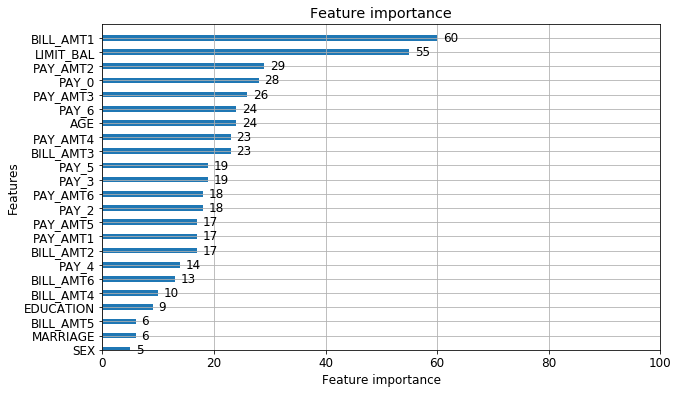

In [206]:
ax = lgb.plot_importance(gbm, height = 0.4, max_num_features=25, xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()

<li>In the cell below, we will compare the <b>classification accuracy </b> versus the <b>null accuracy</b> ( the accuracy that could be achieved by always predicting the most frequent class). We must always compare the two.  </li>

In [187]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.821
The roc_auc_score of prediction is: 0.658105286593
The Null Acccuracy is: 0.7771666666666667


It is a good thing that the prediction accuracy is greater than the null accuracy because it shows us that the model is performing better than just by predicting the most frequent class. 

<h2>Confusion matrix </h2>

In [188]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[4439  224]
 [ 850  487]]




<b>Basic terminology</b>

- <b>True Positives (TP)</b>: we correctly predicted that they would default. 
    - 487
     
     
- <b>True Negatives (TN)</b>: we correctly predicted that they won't default.
    - 4439
     
    
- <b>False Positives (FP)</b>: we incorrectly predicted that they did default.
    - 224
    - Falsely predict positive
    - Type I error
      
       
- <b>False Negatives (FN)</b>: we incorrectly predicted that they didn't default. 
    - 850
    - Falsely predict negative
    - Type II error



In [189]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]

In [190]:
y_pred_prob

array([ 0.38772257,  0.76519256,  0.36600357, ...,  0.20712293,
        0.12989522,  0.07864952])

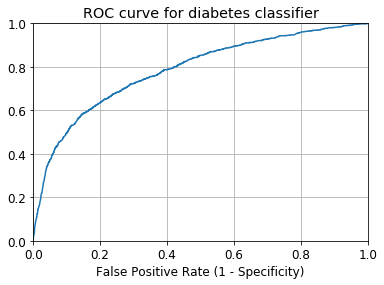

In [191]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [207]:
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.785290670472




- AUC is useful as a single number summary of classifier performance
- Higher value means that it is a better classifier
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
- AUC is useful even when there is high class imbalance (unlike classification accuracy)

